Name: Abdul Wahab

Email: SP21-RCS-001@ISBSTUDENT.COMSATS.EDU.PK

### Table of Contents:
* [1. Basic Data Exploration](#1.-Basic-Data-Exploration)
	* [1.1 Data Distribution](#1.1-Data-Distribution)
	* [1.2 Multicollinearity Analysis](#1.2-Multicollinearity-Analysis)
* [2. Data Fairness Assessment](#2.-Data-Fairness-Assessment)
	* [2.1 Gender and Age Balance](#2.1-Gender-and-Age-Balance)
	* [2.2 Correlation Analysis](#2.2-Correlation-Analysis)
* [3. Classification Model for Credit-Risk Levels](#3.-Classification-Model-for-Credit-Risk-Levels)
* [4. Evaluation of Model Fairness](#4.-Evaluation-of-Model-Fairness)
* [5. K-Anonymization for Data Anonymization](#5.-K-Anonymization-for-Data-Anonymization)

In [1]:
#importing liberaries
import sys
import copy
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

## 1. Basic Data Exploration

In [2]:
GERMAN_CREDIT_DATSET_COLUMN_NAMES = ['status', 'month', 'credit_history',
                                     'purpose', 'credit_amount', 'savings', 'employment',
                                     'investment_as_income_percentage', 'personal_status',
                                     'other_debtors', 'residence_since', 'property', 'age',
                                     'installment_plans', 'housing', 'number_of_credits',
                                     'skill_level', 'people_liable_for', 'telephone',
                                     'foreign_worker', 'credit']


def load_dataset(filepath, column_names=GERMAN_CREDIT_DATSET_COLUMN_NAMES):
    try:
        dataframe = pd.read_csv(
            filepath, sep=' ', header=None, names=column_names)
    except IOError as err:
        print("IOError: {}".format(err))
        sys.exit(1)
    return dataframe

In [3]:
filepath = r'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
dataframe = load_dataset(filepath)
dataframe.head()

,status,month,credit_history,purpose,credit_amount,savings,employment,investment_as_income_percentage,personal_status,other_debtors,...,property,age,installment_plans,housing,number_of_credits,skill_level,people_liable_for,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
# values belong to each category of risk
dataframe.credit.value_counts()

1    700
2    300
Name: credit, dtype: int64

## 1.1 Data Distribution

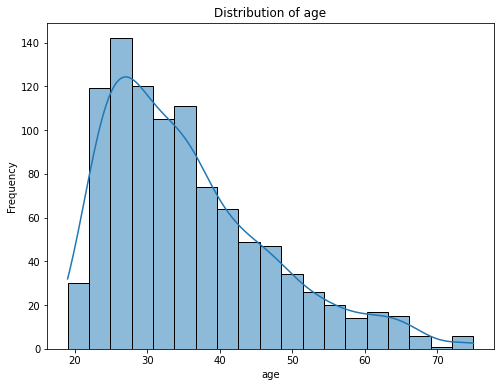

In [5]:
# Plotting distribution for feature 1
plt.figure(figsize=(8, 6))
sns.histplot(dataframe.age, kde=True)
plt.xlabel('age')
plt.ylabel('Frequency')
plt.title('Distribution of age')
plt.show()

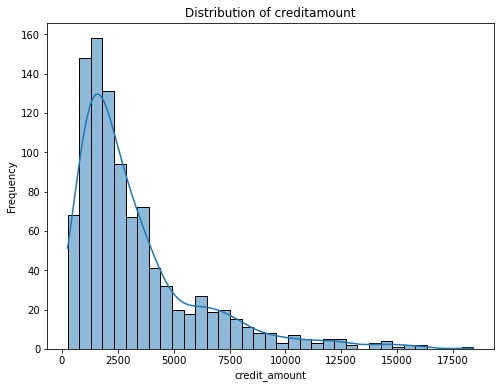

In [6]:
# Plotting distribution for feature 2
plt.figure(figsize=(8, 6))
sns.histplot(dataframe.credit_amount, kde=True)
plt.xlabel('credit_amount')
plt.ylabel('Frequency')
plt.title('Distribution of creditamount')
plt.show()

In [7]:
def preprocess_dataset(dataframe, label_name, protected_attribute_names=["sex"],
                       privileged_classes=[["male"]], favorable_class=1, categorical_features=None,
                       features_to_drop=None):
    # Create a one-hot encoding of the categorical variables.
    categorical_features = sorted(set(categorical_features) - set(features_to_drop),
                                  key=dataframe.columns.get_loc)
    dataframe = pd.get_dummies(
        dataframe, columns=categorical_features, prefix_sep='=')

    # Map protected attributes to privileged/unprivileged
    for attr, vals in zip(protected_attribute_names, privileged_classes):
        privileged_values = [1.]
        unprivileged_values = [0.]
        if callable(vals):
            dataframe[attr] = dataframe[attr].apply(vals)
        else:
            priv = np.logical_or.reduce(
                np.equal.outer(vals, dataframe[attr].to_numpy()))
            dataframe.loc[priv, attr] = privileged_values[0]
            dataframe.loc[~priv, attr] = unprivileged_values[0]

    # map favourable class
    if callable(favorable_class):
        dataframe[label_name] = dataframe[label_name].apply(favorable_class)
    else:
        dataframe[label_name] = (dataframe[label_name]
                                 == favorable_class).astype(int)

    # Drop unrequested columns
    dataframe = dataframe[sorted(set(dataframe.columns.tolist()) - set(features_to_drop),
                                 key=dataframe.columns.get_loc)]

    return dataframe


In [8]:
# To keep it simple, in this tutorial, we shall try to determine whether there is gender bias in the dataset
# and mitigate that.
protected_attribute_names = ['gender']
privileged_classes = [['male']]

# derive the gender attribute from personal_status (you can refer the german.doc)
status_map = {'A91': 'male', 'A93': 'male', 'A94': 'male',
              'A92': 'female', 'A95': 'female'}
dataframe['gender'] = dataframe['personal_status'].replace(status_map)

# target variable
label_name = 'credit'

favorable_label = 1.0  # good credit
unfavorable_label = 0.0  # bad credit
categorical_features = ['status', 'credit_history', 'purpose',
                        'savings', 'employment', 'other_debtors', 'property',
                        'installment_plans', 'housing', 'skill_level', 'telephone',
                        'foreign_worker']
features_to_drop = ['personal_status']

# dataset specific preprocessing
dataframe = preprocess_dataset(dataframe, label_name, protected_attribute_names,
                               privileged_classes, favorable_class=favorable_label,
                               categorical_features=categorical_features,
                               features_to_drop=features_to_drop)
dataframe.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,credit,gender,status=A11,...,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202
0,6,1169,4,4,67,2,1,1,1.0,1,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,0,0.0,0,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,1,1.0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,1.0,1,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,0,1.0,1,...,0,1,0,0,1,0,1,0,1,0


## 1.2 Multicollinearity Analysis

Higher VIF values indicate a stronger degree of multicollinearity among the variables. Generally, VIF values above 5 or 10 are considered to indicate high multicollinearity.

In [9]:
# multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
predictor_variables = ['age', 'credit_amount', 'month']
X = dataframe[predictor_variables]

# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data['Variable'] = predictor_variables
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

        Variable       VIF
0            age  3.065675
1  credit_amount  3.861919
2          month  5.534221


In [10]:
train = dataframe.sample(frac=0.7, random_state=0)
test = dataframe.drop(train.index)

## 2. Data Fairness Assessment
#### Statistical Parity Difference

`Statistical Parity` is checked by computing `Statistical Parity Difference (SPD)`. SPD is the difference between the rate of favorable outcomes received by unprivileged group compared to privileged group. Negative value indicates less favorable outcomes for unprivileged groups.

## 2.1 Gender and Age Balance

In [11]:
filepath = r'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
dataframe = load_dataset(filepath)
dataframe.head()

,status,month,credit_history,purpose,credit_amount,savings,employment,investment_as_income_percentage,personal_status,other_debtors,...,property,age,installment_plans,housing,number_of_credits,skill_level,people_liable_for,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


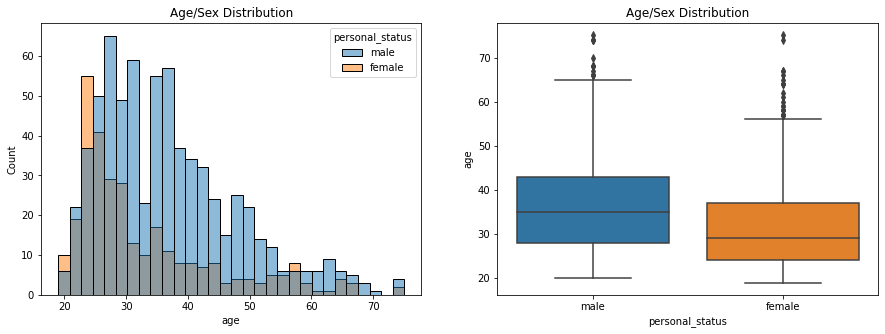

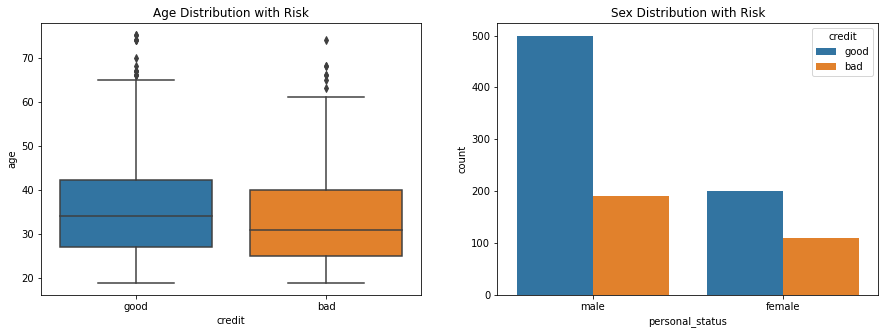

In [12]:
dataframe['personal_status'].replace({'A91':'male','A92':'female','A93':'male','A94':'male','A95':'female'}, inplace = True)
dataframe['credit'].replace({1 :'good', 2:'bad'}, inplace = True)


fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(dataframe, x='age', bins=30, hue="personal_status", ax=ax[0]).set_title("Age/Sex Distribution");
sns.boxplot(data=dataframe, x="personal_status", y="age", ax=ax[1]).set_title("Age/Sex Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=dataframe, x='credit', y='age', ax=ax[0]).set_title("Age Distribution with Risk");
sns.countplot(data=dataframe, x="personal_status", hue="credit", ax=ax[1]).set_title("Sex Distribution with Risk");

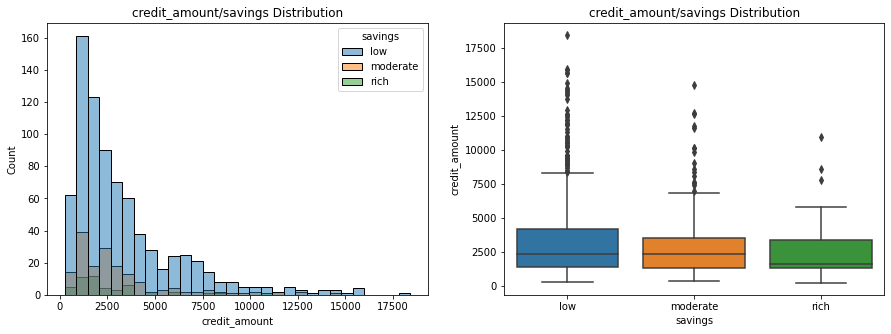

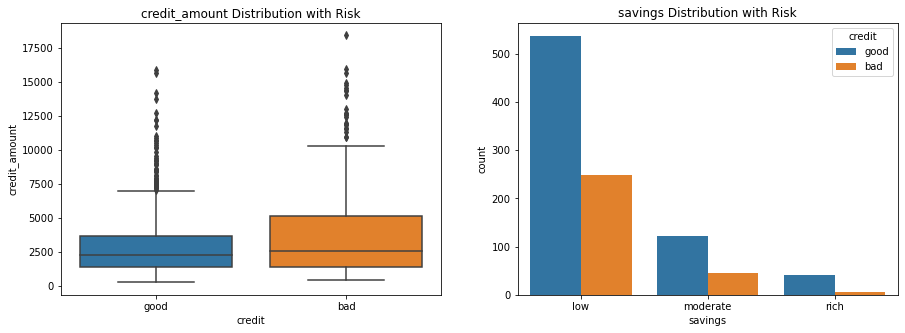

In [13]:
dataframe['savings'].replace( {'A61': 'low', 'A62': 'moderate', 'A63':'moderate','A64':'rich', 'A65':'low'}, inplace = True)

dataframe['credit'].replace({1 :'good', 2:'bad'}, inplace = True)


fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(dataframe, x='credit_amount', bins=30, hue="savings", ax=ax[0]).set_title("credit_amount/savings Distribution");
sns.boxplot(data=dataframe, x="savings", y="credit_amount", ax=ax[1]).set_title("credit_amount/savings Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=dataframe, x='credit', y='credit_amount', ax=ax[0]).set_title("credit_amount Distribution with Risk");
sns.countplot(data=dataframe, x="savings", hue="credit", ax=ax[1]).set_title("savings Distribution with Risk");

In [14]:
# Count the number of instances for each gender
gender_counts = dataframe['personal_status'].value_counts()
print(gender_counts)


male      690
female    310
Name: personal_status, dtype: int64


#### This split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

In [15]:
# Perform stratified sampling during train-test split
from sklearn.model_selection import train_test_split

X = dataframe.drop('personal_status', axis=1)
y = dataframe['personal_status']

# Split the data while maintaining the gender distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
filepath = r'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
dataframe = load_dataset(filepath)
dataframe.head()

,status,month,credit_history,purpose,credit_amount,savings,employment,investment_as_income_percentage,personal_status,other_debtors,...,property,age,installment_plans,housing,number_of_credits,skill_level,people_liable_for,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [17]:
# return `True` if the corresponding row satisfies the `condition` and `False` otherwise
def get_condition_vector(X, feature_names, condition=None):
    if condition is None:
        return np.ones(X.shape[0], dtype=bool)

    overall_cond = np.zeros(X.shape[0], dtype=bool)
    for group in condition:
        group_cond = np.ones(X.shape[0], dtype=bool)
        for name, val in group.items():
            index = feature_names.index(name)
            group_cond = np.logical_and(group_cond, X[:, index] == val)
        overall_cond = np.logical_or(overall_cond, group_cond)

    return overall_cond

##### Compute the number of positives

In [18]:
def get_num_pos_neg(X, y, w, feature_names, label, condition=None):
    y = y.ravel()
    cond_vec = get_condition_vector(X, feature_names, condition=condition)
    return np.sum(w[np.logical_and(y == label, cond_vec)], dtype=np.float64)

##### Compute the number of instances

In [19]:
def get_num_instances(X, w, feature_names, condition=None):
    cond_vec = get_condition_vector(X, feature_names, condition)
    return np.sum(w[cond_vec], dtype=np.float64)

##### Compute the rate of favourable result for a given condition

In [20]:
# Compute the base rate, :`Pr(Y = 1) = P/(P+N)
# Compute the persentage of favourable result for a given condition
def get_base_rate(X, y, w, feature_names, label, condition=None):
    return (get_num_pos_neg(X, y, w, feature_names, label, condition=condition)
            / get_num_instances(X, w, feature_names, condition=condition))

##### Compute fairness in training data

In [21]:
# target value
labels_train = train[label_name].values.copy()

# protected attributes
df_prot = train.loc[:, protected_attribute_names]
protected_attributes = df_prot.values.copy()
privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]

# equal weights for all classes by default in the train dataset
instance_weights = np.ones_like(train.index, dtype=np.float64)

now let's compute the fairness of data with respect to protected attribute

In [22]:
positive_privileged = get_base_rate(protected_attributes, labels_train, instance_weights,
                                    protected_attribute_names,
                                    favorable_label, privileged_groups)

positive_unprivileged = get_base_rate(protected_attributes, labels_train, instance_weights,
                                      protected_attribute_names,
                                      favorable_label, unprivileged_groups)

Let's look at favorable results for privileged & unprivileged groups in terms of statistical parity difference.

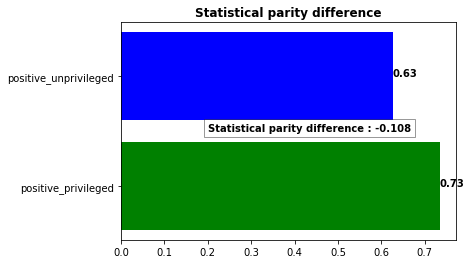

In [23]:
x = ["positive_privileged", "positive_unprivileged"]
y = [positive_privileged, positive_unprivileged]
plt.barh(x, y, color=['green', 'blue'])

for index, value in enumerate(y):
    plt.text(value, index, str(round(value, 2)), fontweight='bold')
plt.text(0.2, 0.5, "Statistical parity difference : " + str(
    round((positive_unprivileged - positive_privileged), 3)),
         bbox=dict(facecolor='white', alpha=0.4), fontweight='bold')
plt.title("Statistical parity difference", fontweight='bold')
plt.show()

Privileged group gets 10.8% more positive outcomes in the training dataset. This is `Bias`. Such Bias must be mitigated.

In [24]:
def statistical_parity_difference(X, y, w, feature_names, label, privileged_groups, unprivileged_groups):
    positive_privileged = get_base_rate(X, y, w, feature_names, label, privileged_groups)
    positive_unprivileged = get_base_rate(X, y, w, feature_names, label, unprivileged_groups)
    return (positive_unprivileged - positive_privileged)

Let's store the fairnes of data in a variable

In [25]:
original_spd = statistical_parity_difference(protected_attributes,
                                         labels_train, instance_weights,
                                         protected_attribute_names, favorable_label,
                                         privileged_groups, unprivileged_groups)

In [26]:
# get the only privileged condition vector for the given protected attributes
# Values are `True` for the privileged values else 'False'
privileged_cond = get_condition_vector(
    protected_attributes,
    protected_attribute_names,
    condition=privileged_groups)

# Get the only unprivileged condition vector for the given protected attributes
# Values are `True` for the unprivileged values else 'False)
unprivileged_cond = get_condition_vector(
    protected_attributes,
    protected_attribute_names,
    condition=unprivileged_groups)

In [27]:
# get the favorable(postive outcome) condition vector
# Values are `True` for the favorable values else 'False'
favorable_cond = labels_train.ravel() == favorable_label

# get the unfavorable condition vector
# Values are `True` for the unfavorable values else 'False'
unfavorable_cond = labels_train.ravel() == unfavorable_label

In [28]:
# combination of label and privileged/unprivileged groups

# Postive outcome for privileged group
privileged_favorable_cond = np.logical_and(favorable_cond, privileged_cond)

# Negative outcome for privileged group
privileged_unfavorable_cond = np.logical_and(unfavorable_cond, privileged_cond)

# Postive outcome for unprivileged group
unprivileged_favorable_cond = np.logical_and(favorable_cond, unprivileged_cond)

# Negative outcome for unprivileged group
unprivileged_unfavorable_cond = np.logical_and(unfavorable_cond, unprivileged_cond)

We need total number of instances, privileged, unprivileged, favorable outcomes, etc..

In [29]:
instance_count = train.shape[0]
privileged_count = np.sum(privileged_cond, dtype=np.float64)
unprivileged_count = np.sum(unprivileged_cond, dtype=np.float64)
favourable_count = np.sum(favorable_cond, dtype=np.float64)
unfavourable_count = np.sum(unfavorable_cond, dtype=np.float64)

privileged_favourable_count = np.sum(privileged_favorable_cond, dtype=np.float64)
privileged_unfavourable_count = np.sum(privileged_unfavorable_cond, dtype=np.float64)
unprivileged_favourable_count = np.sum(unprivileged_favorable_cond, dtype=np.float64)
unprivileged_unfavourable_count = np.sum(unprivileged_unfavorable_cond, dtype=np.float64)

Now, let us analyze above variables and see how the frequency of count is distributed for protected attribute.

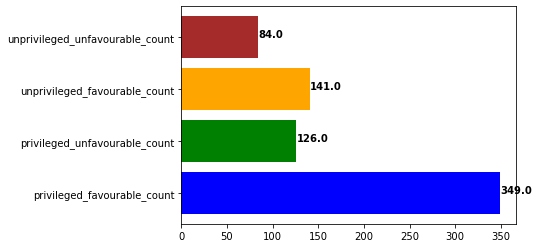

In [30]:
x = ["privileged_favourable_count", "privileged_unfavourable_count",
     "unprivileged_favourable_count", "unprivileged_unfavourable_count"]
y = [privileged_favourable_count, privileged_unfavourable_count, unprivileged_favourable_count,
     unprivileged_unfavourable_count]
plt.barh(x, y, color=['blue', 'green', 'orange', 'brown'])

for index, value in enumerate(y):
    plt.text(value, index,
             str(value), fontweight='bold')
plt.show()

##### Privileged and unprivileged group outcomes

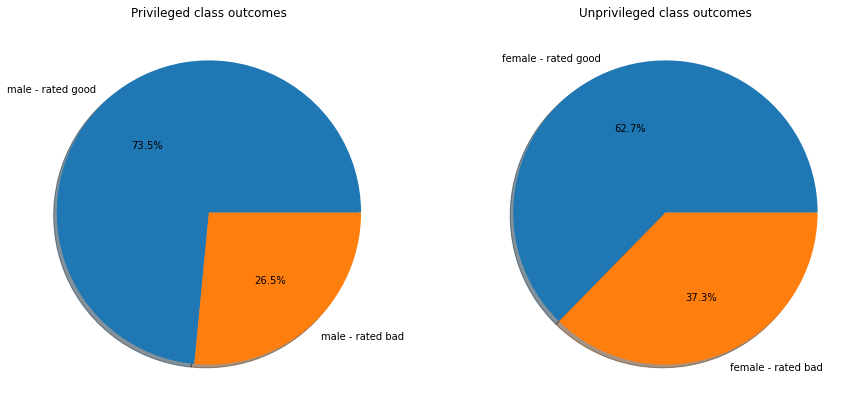

In [31]:
labels_privileged = ['male - rated good', 'male - rated bad']
sz_privileged = [privileged_favourable_count, privileged_unfavourable_count]
labels_unprivileged = ['female - rated good', 'female - rated bad']
sz_unpriveleged = [unprivileged_favourable_count, unprivileged_unfavourable_count]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.pie(sz_privileged, labels=labels_privileged, autopct='%1.1f%%', shadow=True)
ax1.title.set_text('Privileged class outcomes')

ax2.pie(sz_unpriveleged, labels=labels_unprivileged, autopct='%1.1f%%', shadow=True)
ax2.title.set_text('Unprivileged class outcomes')
plt.show()

There is a bias against the unprivileged group as privileged group gets 10.8% more positive outcomes.

## 2.2 Correlation Analysis

In [32]:
# Select the two features you want to assess for correlation
feature1 = 'age' # status_sex
feature2 = 'people_liable_for'

# Calculate the correlation coefficient
correlation_coefficient = dataframe[feature1].corr(dataframe[feature2])

# Print the correlation coefficient
print("Correlation coefficient between", feature1, "and", feature2, ":", correlation_coefficient)


Correlation coefficient between age and people_liable_for : 0.11820083281906714


#### The correlation between the feature “A9:Personal status and sex” and the “Attribute 18:Number of people being liable to provide maintenance for”. is not possible due to their data types, so I choose "Age" instead on "Personal_Status".

In [33]:
# reweighing weights
weight_privileged_favourable = favourable_count * privileged_count / (instance_count * privileged_favourable_count)
weight_privileged_unfavourable = unfavourable_count * privileged_count / (instance_count * privileged_unfavourable_count)
weight_unprivileged_favourable = favourable_count * unprivileged_count / (instance_count * unprivileged_favourable_count)
weight_unprivileged_unfavourable = unfavourable_count * unprivileged_count / (instance_count * unprivileged_unfavourable_count)

In [34]:
transformed_instance_weights = copy.deepcopy(instance_weights)

In [35]:
transformed_instance_weights[privileged_favorable_cond] *= weight_privileged_favourable
transformed_instance_weights[privileged_unfavorable_cond] *= weight_privileged_unfavourable
transformed_instance_weights[unprivileged_favorable_cond] *= weight_unprivileged_favourable
transformed_instance_weights[unprivileged_unfavorable_cond] *= weight_unprivileged_unfavourable

In [36]:
mitigated_spd = statistical_parity_difference(protected_attributes,
                                          labels_train, transformed_instance_weights,
                                          protected_attribute_names, favorable_label,
                                          privileged_groups, unprivileged_groups)

In [37]:
def plot_fairness_comp(original, mitigated, metric="SPD"):
    plt.figure(facecolor='#FFF00F', figsize=(4, 4))
    plt.bar(["Original", "Mitigated"], [
            original, mitigated], color=["blue", "green"])
    plt.ylabel(metric)
    plt.title("Before vs After Bias Mitigation", fontsize=15)
    y = [original, mitigated]
    for index, value in enumerate(y):
        if value < 0:
            plt.text(index, value - 0.001,
                     str(round(value, 3)), fontweight='bold', color='red',
                     bbox=dict(facecolor='red', alpha=0.4))
        else:
            plt.text(index, value + 0.001,
                     str(round(value, 3)), fontweight='bold', color='red',
                     bbox=dict(facecolor='red', alpha=0.4))
    plt.grid(None, axis="y")
    plt.show()

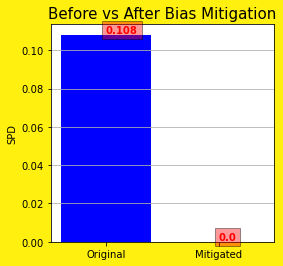

In [38]:
plot_fairness_comp(abs(original_spd),abs(mitigated_spd),metric="SPD")

Reweighing algorithm has proven to be highly effective in reducing data bias, as it results in a Statistical Parity Difference of `zero`. This algorithm enables us to address and minimize bias in the data by adjusting the weights of certain groups.

Now that we have both original and bias mitigated data, let's evaluate model fairness before and after bias mitigation.

## 3. Classification Model for Credit-Risk Levels

##### Compute fairness of the different ML models
To compute model fairness SPD let us specify privileged & unprivileged groups, protected attributes and instance weights to be considered in the test data set.

In [39]:
# protected attribute
df_prot_test = test.loc[:, protected_attribute_names]
protected_attributes_test = df_prot_test.values.copy()
privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]
# equal weights for all classes by default in the testing dataset
instance_weights_test = np.ones_like(test.index, dtype=np.float64)

In [40]:
# split the features and labels for both train and test data
from sklearn.preprocessing import StandardScaler
feature_names = [n for n in train.columns if n not in label_name]
X_train, X_test, Y_train, Y_test = train[feature_names].values.copy(), test[
    feature_names].values.copy(), train[label_name].values.copy(), test[label_name].values.copy()
# standardize the inputs
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(X_train)
X_test = scale_orig.fit_transform(X_test)

In [41]:
## sklearn to work with ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc

In [42]:
def train_model(clf, x_train, y_train, **kwargs):
    # Instantiate the classification model
    if "sample_weight" in kwargs:
        clf.fit(x_train, y_train.ravel(),
                sample_weight=kwargs["sample_weight"])
    else:
        clf.fit(x_train, y_train)
    return clf

In [43]:
# prepare list of models
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier(random_state=4)))
models.append(('SVM', SVC(probability=True)))

## 4. Evaluation of Model Fairness

In [44]:
ml_models, accuracy_list, roc_auc_list, spd_list = [], [], [], []
for name, model in models:
    # evaluate the base model
    clf = train_model(model, X_train, Y_train,sample_weight=instance_weights)
    y_score = clf.predict_proba(X_test)[:, 1]
    predicted = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, predicted)
    fpr, tpr, _ = roc_curve(Y_test, predicted)
    roc_auc = auc(fpr, tpr)
    # compute SPD for base model
    spd = statistical_parity_difference(protected_attributes_test,
                                                  predicted, instance_weights_test,
                                                  protected_attribute_names, favorable_label,
                                                  privileged_groups, unprivileged_groups)
    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    spd_list.append(spd)
    ml_models.append(name)

In [45]:
before_debiasing = defaultdict(dict)
before_debiasing["SPD"] = spd_list
before_debiasing["Accuracy"] = accuracy_list
before_debiasing["AUC"] = roc_auc_list

In [46]:
ml_models, accuracy_list, roc_auc_list, spd_list = [], [], [], []
for name, model in models:
    # evaluate the mitgated model
    clf = train_model(model, X_train, Y_train,sample_weight=transformed_instance_weights)
    y_score = clf.predict_proba(X_test)[:, 1]
    predicted = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, predicted)
    fpr, tpr, _ = roc_curve(Y_test, predicted)
    roc_auc = auc(fpr, tpr)
    # compute SPD for base model
    spd = statistical_parity_difference(protected_attributes_test,
                                                  predicted, instance_weights_test,
                                                  protected_attribute_names, favorable_label,
                                                  privileged_groups, unprivileged_groups)
    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    spd_list.append(spd)
    ml_models.append(name)

In [47]:
after_debiasing = defaultdict(dict)
after_debiasing["SPD"] = spd_list
after_debiasing["Accuracy"] = accuracy_list
after_debiasing["AUC"] = roc_auc_list

##### Graphical representation

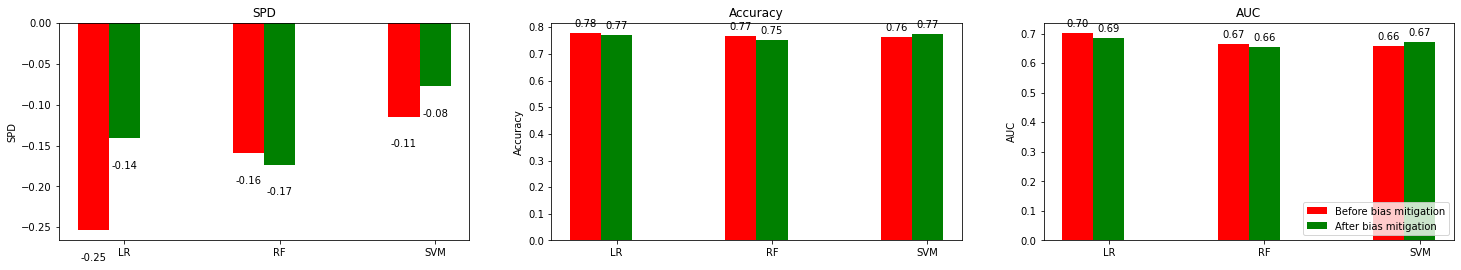

In [48]:
def autolabel(rects, axes):
        for rect in rects:
            h = rect.get_height()
            if h < 0:
                axes.text(rect.get_x() + rect.get_width() / 2., h - 0.04, '%.2f' % float(h),
                          ha='center', va='bottom')
            else:
                axes.text(rect.get_x() + rect.get_width() / 2., 1.02 * h, '%.2f' % float(h),
                          ha='center', va='bottom')
ind = np.arange(len(ml_models))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, axs = plt.subplots(1, 3, figsize=(25, 4))

for ax,metric in zip (axs.ravel(),after_debiasing.keys()):
    fairness_base_bar = ax.bar(ind, before_debiasing[metric], width, color='r',
                        label='Before bias mitigation')
    fairness_mitigated_bar = ax.bar(ind + width, after_debiasing[metric], width, color='g',
                                     label='After bias mitigation')
    ax.set_ylabel(metric)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(ml_models)
    ax.title.set_text(metric)
    autolabel(fairness_base_bar, axes=ax)
    autolabel(fairness_mitigated_bar, axes=ax)
plt.legend(loc ="lower right")
plt.show()

## 5. K-Anonymization for Data Anonymization

In [49]:
import anonypy
filepath = r'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
anon = load_dataset(filepath)
anon.head()

,status,month,credit_history,purpose,credit_amount,savings,employment,investment_as_income_percentage,personal_status,other_debtors,...,property,age,installment_plans,housing,number_of_credits,skill_level,people_liable_for,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [50]:
# I have chosen these 3 columns
anon = anon[['personal_status', 'purpose', 'age']]

anon.head()

,personal_status,purpose,age
0,A93,A43,67
1,A92,A43,22
2,A93,A46,49
3,A93,A42,45
4,A93,A40,53


In [51]:
def k_anonymize(dataset, columns):

    anon_dataset = dataset.copy()
    
    # Target all sensitive columns
    for column in columns:
        column_label = column['label']
        if column['type'] == 'suppressed':
            # Replace all characters with asterix
            anon_dataset[column_label] = ['*' for x in anon_dataset[column_label]]
        
        if column['type'] == 'semi-suppressed':
            # Replace 70% of the characters with asterix
            anon_dataset[column_label] = [('*'*(round(len(x)*.7)) + x[(round(len(x)*.7)):]) for x in anon_dataset[column_label]]
        
        if column['type'] == 'generalized':
            # Summarize the data using ranges
            for i in range(len(anon_dataset[column_label])):
                # convert column type from int to string
                anon_dataset[column_label] = anon_dataset[column_label].astype(str)
                x = int(anon_dataset[column_label][i])
                if x <= 40: anon_dataset[column_label][i] =  "0-40"
                if x > 40 and x <= 60: anon_dataset[column_label][i] =  "40-60"
                if x > 60 and x <= 100: anon_dataset[column_label][i] =  "> 60"

    return anon_dataset

# Describe the columns and their respective anonymization type
columns = [{"label": "personal_status", "type": "suppressed"},
    {"label": "purpose", "type": "semi-suppressed"},
    {"label": "age", "type": "generalized"}]
dataset = anon
anonymized_dataset = k_anonymize(dataset, columns)

In [52]:
anon.head()

,personal_status,purpose,age
0,A93,A43,67
1,A92,A43,22
2,A93,A46,49
3,A93,A42,45
4,A93,A40,53


In [53]:
anonymized_dataset.head()

,personal_status,purpose,age
0,*,**3,> 60
1,*,**3,0-40
2,*,**6,40-60
3,*,**2,40-60
4,*,**0,40-60
